# Predict calorie expenditure

In [1]:
# Libraries

## Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns

import math

## Plotting
import matplotlib.pyplot as plt

# Basic cleaning
## Variance
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from scipy.stats import iqr

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer, TransformedTargetRegressor

## Load dataset

In [2]:
# Load datasets

# Paths
calorie_train_data_path = "../data/raw_data/train.csv"

# Read train data
data=pd.read_csv(calorie_train_data_path,index_col='id')
display(f"Shape of data : {data.shape}")

'Shape of data : (750000, 8)'

In [3]:
# Copy of datasets
data_copy = data.copy()

## Quick exploration

In [4]:
# Overview of the first lines
data.head(2)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0


In [5]:
# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


In [6]:
# Descriptive statistics
data.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [7]:
def plot_histplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.histplot(data=num_df,kde=True, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

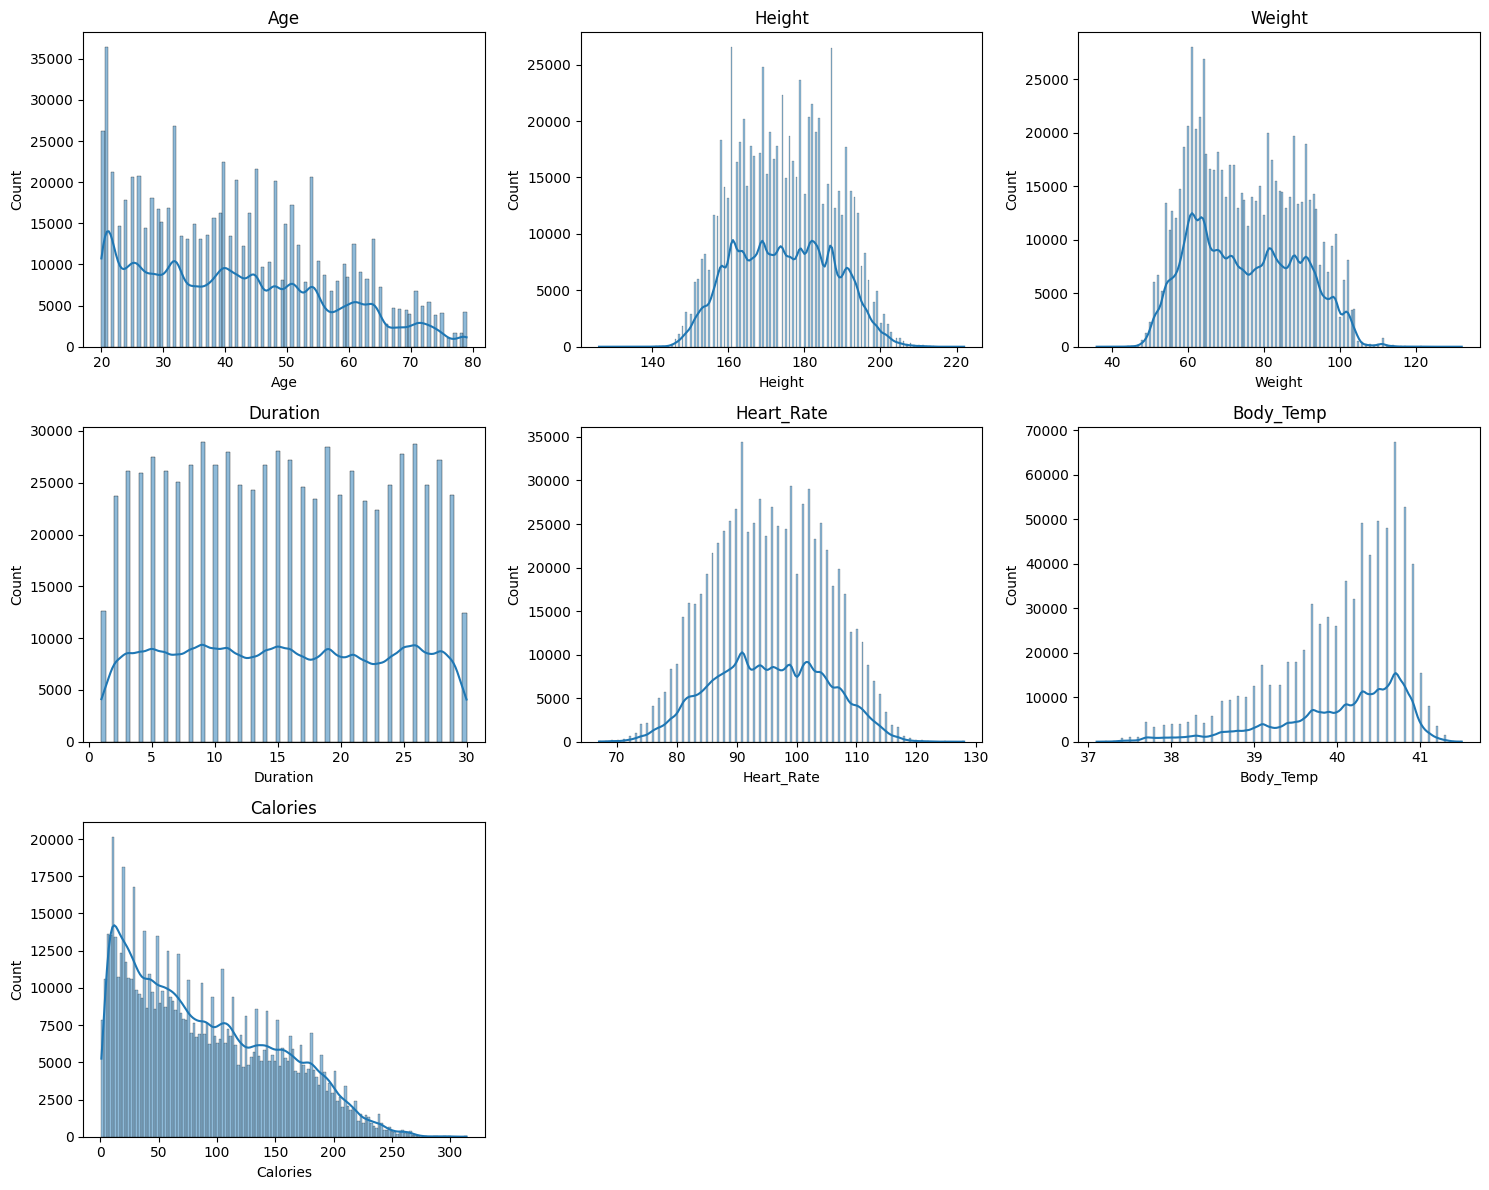

In [8]:
# Display hist plots for numerical features.
plot_histplot_sns(data)

In [9]:
# visualize a uniform quantile transform of the sonar dataset 
from sklearn.preprocessing import QuantileTransformer 
from matplotlib import pyplot

# # retrieve just the numeric input values 
# data = dataset.values[:, :-1]

num_data = data.drop(columns=['Sex'])
# perform a uniform quantile transform of the dataset
trans = QuantileTransformer(n_quantiles=100, output_distribution='uniform') 
num_data_transformed = trans.fit_transform(num_data)
num_data_transformed = pd.DataFrame(num_data_transformed, columns=num_data.columns, index=num_data.index)

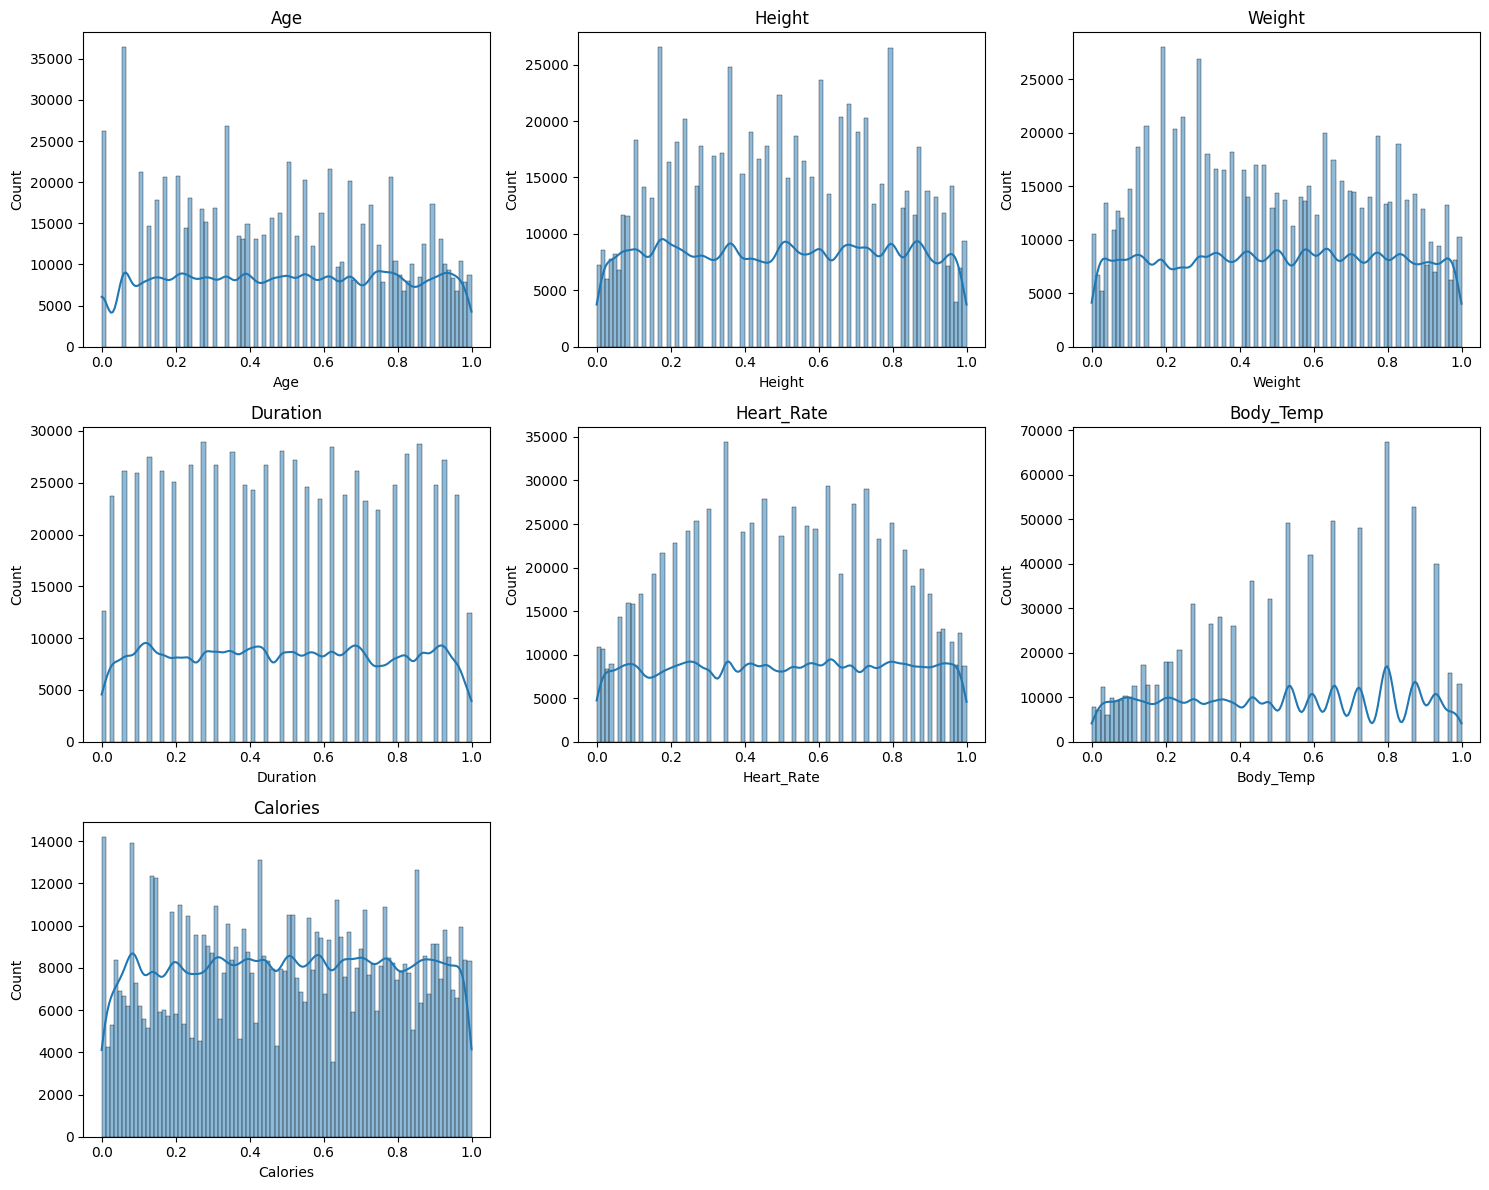

In [10]:
# Display hist plots for numerical features.
plot_histplot_sns(num_data_transformed)

In [11]:
def plot_boxplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.boxplot(data=num_df, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

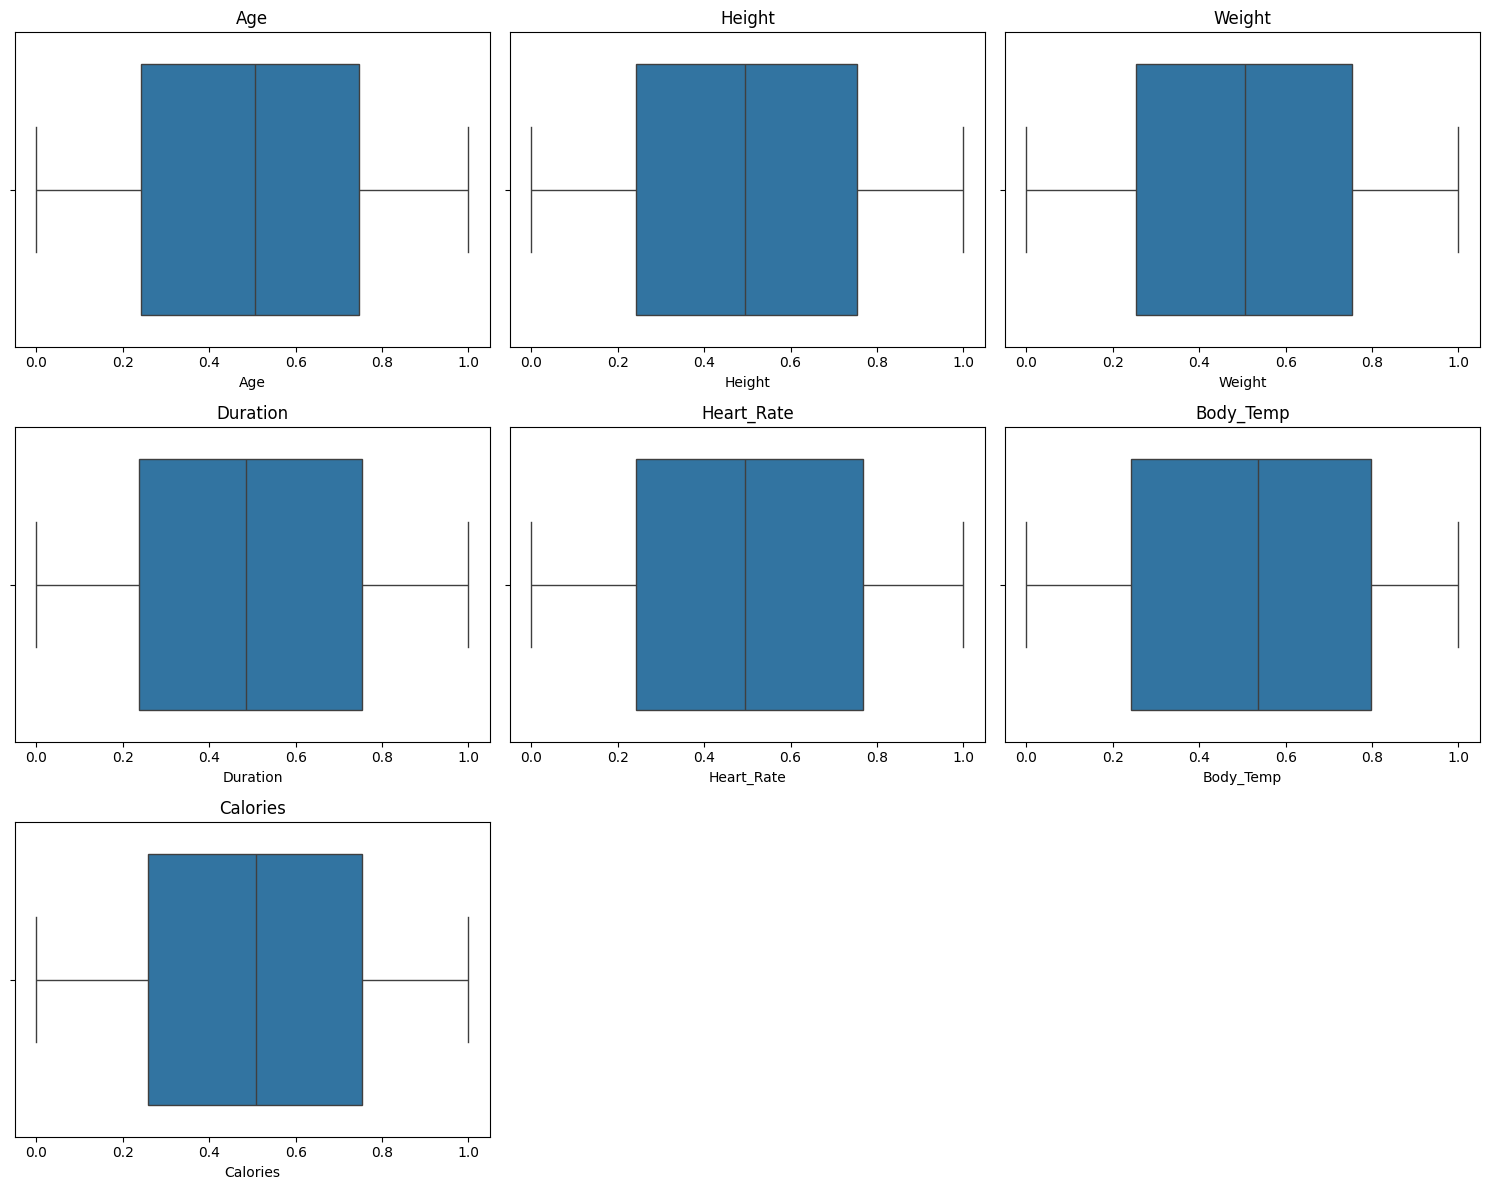

In [12]:
# Display box plots for numerical features.
plot_boxplot_sns(num_data_transformed)

In [13]:
print i 

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (469446080.py, line 1)

In [ ]:
def plot_countplot_sns(df):
        """
    Plots Seaborn countplots of categorical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of categorical columns
    """
        #Only select categorical features         
        cat_df = df.select_dtypes(exclude='number')

        vars = cat_df.columns
        n = len(cat_df.columns)
        cols = 3
        rows = math.ceil(n / cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        axes = axes.flatten()

        for i, var in enumerate(vars):
            sns.countplot(data=cat_df, x=var, ax=axes[i])
            axes[i].set_title(var)

        # Delete unused subplots
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

In [ ]:
# Display count plots for non-numerical features.
plot_countplot_sns(data)

In [ ]:
def plot_boxplot_sns(df):
    """
    Plots Seaborn histograms of numerical columns
    Args:
        df (DataFrame): Raw data
    Returns:
        Subplot grids of numerical columns
    """
    #Only select numerical features 
    num_df = df.select_dtypes(include='number')
        
    vars = num_df.columns
    n = len(num_df.columns)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()

    for i, var in enumerate(vars):
        sns.boxplot(data=num_df, x=var, ax=axes[i])
        axes[i].set_title(var)

    # Delete unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
# Display box plots for numerical features.
plot_boxplot_sns(data)

## Data cleaning

### Basic data cleaning

🔍 **Why Data Cleaning Matters**
- Essential in every ML project; often skipped at a cost.
- Prevents model failure and misleading performance results.
- Helps prepare trustworthy, high-quality datasets.

#### Identify Columns That Contain a Single Value

🧮 **Identify Columns with a Single Unique Value**
- **Problem**: Zero-variance predictors (e.g., all values = 1.0).
- **Detection**: Use .nunique() or NumPy’s unique() function.
- **Action**: Remove these columns—they add no information and can cause errors.

In [ ]:
# Summurize the number of unique values in each column
data.nunique()

#### Delete Columns That Contain a Single Value

🗑️ **Delete Columns with a Single Value**
- Use Pandas drop() after identifying the column(s).

In [ ]:
# Create a function to drop columns that have a single value
def drop_single_value_columns(df : pd.DataFrame) -> pd.DataFrame:
        """
    Drop columns with a single unique value 
    Args:
        df (DataFrame): Raw data
    Returns:
        df (DataFrame) with no single value columns
    """ 
        print(f"Shape BEFORE dropping single value columns: {df.shape}") 
        
        # get number of unique values for each column 
        counts = df.nunique()
        
        # record columns to delete (i.e columns that only contain a unique value)
        to_del = [i for i,v in enumerate(counts) if v == 1]
    
        print(f"Names of single value columns: {to_del}") 
        
        # drop useless columns 
        df.drop(to_del, axis=1, inplace=True) 
        
        print(f"Shape AFTER dropping single value columns: {df.shape}") 
        return df

In [ ]:
data = drop_single_value_columns(data)

#### Consider Columns That Have Very Few Values

🤔 **Consider Columns with Very Few Unique Values**
- Known as near-zero variance predictors.
- These may be:<br>
o	Categorical in disguise.<br>
o	Indicators needing encoding (ordinal/categorical).
- Check: Unique values as % of total rows (e.g., <1%).


In [ ]:
# Create a function that print index, number of unique values and percentage of unique values per column in regard to total number of rows per column
def show_unique_values_percentage(df : pd.DataFrame):
    """
    Print index, number of unique values and percentage of unique values 
    per column in regard to total number of rows per column
    Args:
        - df (DataFrame): Raw data
    """  
    for i in range(df.shape[1]):
        num = df.nunique().values[i]
        percentage = float(num) / df.shape[0] * 100
        print(f"{i}, {df.columns[i]}, {num}, {round(percentage,5)}%")

In [ ]:
show_unique_values_percentage(data)

All columns have very few unique values in regards to the total number of instances. <br> **For the moment, we keep them all.**

#### Remove columns that have a low variance

✂️ **Remove Columns with Low Variance**
- Use **VarianceThreshold** from sklearn.feature_selection.
- **Threshold Tuning**: Try 0.0 to 0.5; see feature reduction effects.
- Lower variance = less informational value, possibly noise.
- Helps dimensionality reduction while retaining meaningful features.

In [ ]:
# explore the effect of the variance thresholds on the number of selected features 
def explore_variance_threshold_effects(df : pd.DataFrame, range : np.arange):
    """
    Explore the effect of the variance thresholds on 
    the number of selected features from numpy import arange 
    Args:
        - df (DataFrame): Raw data
        - range (np.arange) : variance range to check
    Returns:
        - Print number of features whose variance is over the considered threshold
        - Plot the number of features whose variance is over the considered threshold
    """ 
    
    # apply transform with each threshold 
    results = list() 

    for t in range: 
        # define the transform 
        transform = VarianceThreshold(threshold=t) 
        
        # transform the input data 
        df_sel = transform.fit_transform(df) 
        
        # determine the number of input features 
        n_features = df_sel.shape[1] 
        
        print(f">Threshold={round(t,2)}, Features={n_features}")
        
        # store the result 
        results.append(n_features) 
        
    # plot the threshold vs the number of selected features 
    plt.plot(range, results) 
    plt.show()

In [ ]:
# split data into inputs (ONLY NUMERICAL FOR NOW) and outputs 
data_num = data.select_dtypes(include="number")

data_val = data_num.values 
X = data_val[:, :-1] 
y = data_val[:, -1] 
print(X.shape, y.shape) 

# define variance thresholds to check 
# thresholds = np.arange(0.0, 0.55, 0.05) 
thresholds = np.arange(0.0, 0.5, 0.05) 

explore_variance_threshold_effects(X, thresholds)

**Conclusion** : The numerical features all have a **variance > 0.5**.<br> **We keep them all for the moment.**

#### Identify rows that contain duplicate data

🧍 **Identify Duplicate Rows**
- **Problem**: Inflated priors, biased evaluation (e.g., in cross-validation).
- **Action**: Check .duplicated() in Pandas.
- **Best Practice**: Test model performance with/without duplicates.

In [ ]:
# calculate duplicates 
dups = data.duplicated() 

# report if there are any duplicates 
print(dups.any()) 

# list all duplicate rows 
print(data[dups])

#### Delete rows thtat contain duplicate data

In [ ]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        - df (Dataframe) without duplicated rows, a string otherwise.
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    num_dups = df.duplicated().sum()
    
    print(f"Number of duplicated rows : {num_dups}")

    if df.duplicated().any():
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print(f"{num_dups} duplicated row(s) removed")
        return df_no_duplicates
    else:
        return "No duplicated rows found !"    

In [ ]:
# Check for duplicates ; if found, duplicates are dropped.
data_no_dups = check_duplicates(data)

### Outlier Identification and Removal

✅ **Why Care About Outliers**?
- Outliers = observations significantly different from others.
- Can distort models, reduce performance.
- Causes: measurement error, data corruption, or genuine anomaly.

📌 **Best Practices**
- Always visualize outliers (scatter plots, boxplots).
- Understand domain before deciding to remove outliers.
- Test model performance before/after removal.
- Combine statistical and model-based methods when needed.

In [ ]:
# Display box plots for numerical features.
plot_boxplot_sns(data_no_dups)

**At the moment, based on the domain of expertise, we do not get rid of outliers.**

### How to Mark and Remove Missing Data

🔍 **Understanding Missing Data in ML**
- Real-world datasets often contain **missing or corrupt** values (e.g., due to non-recording or corruption).
- Many machine learning algorithms **cannot handle missing values** and will raise errors.

📌 **Key Takeaways for Data Scientists**
- Use **domain knowledge** to identify invalid values
- Replace invalid values with **NaN** to mark them
- Understand which algorithms are **sensitive to NaNs**
- Start with **row removal**, but consider **imputation** in practice

In [ ]:
# Check the sum of Nan values in the dataset
data_no_dups.isnull().sum()

There ar no nan values in the train dataset (with no duplicates). <br> No zero values that can be considered odd or nan.<br> **We do not need to take action here.**

## Baseline modeling

In [ ]:
def check_duplicates(df):
    """
    Counts duplicated rows. If any, function drops duplicated rows.
    Args:
        df (DataFrame): Raw data
    Returns:
        - df (Dataframe) without duplicated rows, a string otherwise.
    """

    # Check number of rows before removing duplicates
    print(f"Number of rows : {len(df)}")

    # Compute the number of duplicated rows
    num_dups = df.duplicated().sum()
    
    print(f"Number of duplicated rows : {num_dups}")

    if df.duplicated().any():
        # Remove duplicates
        df_no_duplicates = df.drop_duplicates()
        print(f"{num_dups} duplicated row(s) removed")
        return df_no_duplicates
    else:
        return "No duplicated rows found !"    

In [ ]:
# load the dataset
def load_dataset(filename, target):
    """
    - Load dataset as a Pandas dataframe
    - Counts duplicated rows. If any, function drops duplicated rows.
    - Create X (features) and y (target)
    Args:
        df (DataFrame): Raw data
    Returns:
        - X and y (as Pandas dataframes)
    """
    # load the dataset
    data = pd.read_csv(filename, index_col='id') 

    #Check duplicates (Any duplicated rows are dropped)
    data_no_dups = check_duplicates(data)
    
    # split into input and output variables
    X = data_no_dups.drop(columns=[target])
    y = data_no_dups[[target]]
    
    return X, y

In [ ]:
# prepare input data
def prepare_inputs(X_train, X_test, column): 
    """
    - Prepare input features
    - One Hot Encoding of the only categorical feature
    Args:
        - X_train (Dataframe)
        - X_test (Dataframe)
        - Column (list) : Name of the categorical feature
    Returns:
        - X_train_scaled and X_test_scaled (as Pandas dataframes)
    """
    preproc_categorical = make_pipeline(OneHotEncoder(drop='if_binary', sparse_output=False))
    preproc = make_column_transformer((preproc_categorical,column), remainder='passthrough')

    preproc.fit(X_train)
    X_train_enc = preproc.transform(X_train)
    X_test_enc = preproc.transform(X_test)

    # Transform to dataframes
    X_train_enc = pd.DataFrame(X_train_enc, columns=preproc.get_feature_names_out())
    X_test_enc = pd.DataFrame(X_test_enc, columns=preproc.get_feature_names_out())
    
    return X_train_enc, X_test_enc

In [ ]:
# prepare input data
def prepare_inputs_global(X_train, X_test): 
    """
    - Prepare input features
    Args:
            XXXX
    Returns:
        - X_train_scaled and X_test_scaled (as Pandas dataframes)
    """
    # Prepare pipelines
    preproc_categorical = make_pipeline(OneHotEncoder(drop='if_binary', sparse_output=False))
    preproc_numerical = make_pipeline(MinMaxScaler())

    # Prepare features columns names
    categorical_columns = X_train.select_dtypes(exclude='number').columns.tolist()
    numerical_columns = X_train.select_dtypes(include='number').columns.tolist()

    # Prepare column transformer
    preproc = make_column_transformer((preproc_categorical,categorical_columns), 
                                      (preproc_numerical, numerical_columns))

    preproc_test=preproc
    
    # Fit column transformer on data
    preproc.fit(X_train)

    # Tranform data via fitted column transformer 
    X_train_enc = preproc.transform(X_train)
    X_test_enc = preproc.transform(X_test)

    # Transform to dataframes
    X_train_enc = pd.DataFrame(X_train_enc, columns=preproc.get_feature_names_out())
    X_test_enc = pd.DataFrame(X_test_enc, columns=preproc.get_feature_names_out())
    
    return X_train_enc, X_test_enc, preproc

In [ ]:
# Define the root mean squared logaritmic error
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred, squared=True))

# Define a RMSLE scorer
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

In [ ]:
def rmsle_manually(y_true, y_pred):
    squared_log_errors = (np.log(y_pred + 1) - np.log(y_true + 1))**2
    return np.sqrt(np.mean(squared_log_errors))

# Define a RMSLE scorer
rmsle_scorer_manually = make_scorer(rmsle_manually, greater_is_better=False)

In [ ]:
def safe_rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Define a RMSLE scorer
safe_rmsle_scorer_manually = make_scorer(safe_rmsle, greater_is_better=False) 

In [ ]:
# numerical_columns_w_outliers, numerical_columns_no_outliers = extract_cols_outliers(X_train)

In [ ]:
# # Paths
# calorie_train_data_path = "../data/raw_data/train.csv"
# target_name = "Calories"

# # Load dataset
# X,y = load_dataset(calorie_train_data_path,target_name)

# # split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) 

# # Prepare pipelines
# preproc_categorical = make_pipeline(OneHotEncoder(drop='if_binary', sparse_output=False))
# preproc_numerical = make_pipeline(MinMaxScaler())

# # Prepare features columns names
# categorical_columns = X_train.select_dtypes(exclude='number').columns.tolist()
# numerical_columns = X_train.select_dtypes(include='number').columns.tolist()

# preproc = make_column_transformer((OneHotEncoder(drop='if_binary', sparse_output=False),categorical_columns),
#                                  (MinMaxScaler(), numerical_columns))

# # define and configure the model
# model = RandomForestRegressor()
# pipeline = make_pipeline(preproc,model)

# display(pipeline)
# type(y_train)

# # evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, X_train, y_train.to_numpy(), scoring=rmsle_scorer, cv=cv, n_jobs=-1)

# # # report model performance
# # print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# y_train.to_numpy()

In [ ]:
# # Paths
# calorie_train_data_path = "../data/raw_data/train.csv"
# target_name = "Calories"
# categorical_features = ["Sex"]

# # Load dataset
# X,y = load_dataset(calorie_train_data_path,target_name)

# # split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) 

# # prepare input data (encode categorical column ONLY)
# X_train_enc, X_test_enc = prepare_inputs(X_train, X_test, categorical_features) 

# # define and configure the model
# model = LinearRegression()

# # evaluate the model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train_enc, y_train, scoring='neg_mean_squared_log_error', cv=cv, n_jobs=-1)

# # report model performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))